## Mobility Fitting Module

Kawin supplies some utilities to aid in mobility model generation and optimization. The module includes:
- Compatibility with Espei parameter generation
- Manual least squares fitting (intended for situations when mobility data does not exists at the endmembers of a phase)
- Liquid mobility
- Compatibility with Espei parameter optimization

This example will go through the following steps to generate and optimize mobility for the Cu-Ni system. This first example goes over parameter generation.

First we need a thermodynamic database. This one is taken from S. Mey, Calphad 16:3 (1992) 255.

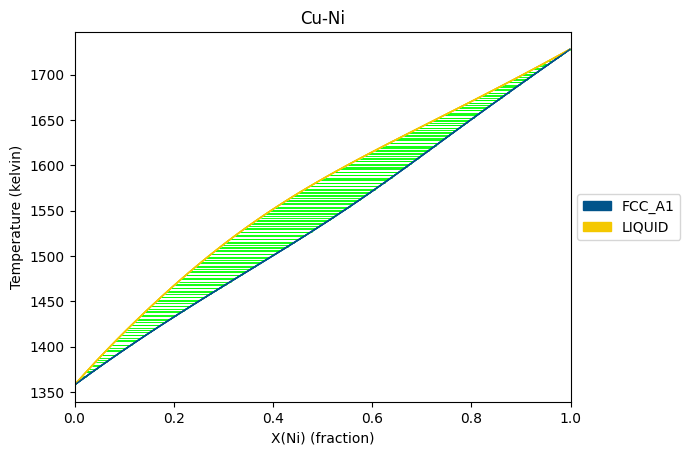

In [1]:
import matplotlib.pyplot as plt
from pycalphad import Database, variables as v
from pycalphad.mapping import BinaryStrategy, plot_binary

dbf = Database('databases/CuNi.tdb')
comps = ['CU', 'NI', 'VA']
phases = ['FCC_A1', 'LIQUID']
conds = {v.T: (1200, 1800, 20), v.P: 101325, v.X('NI'): (0, 1, 0.01)}

strategy = BinaryStrategy(dbf, comps, phases, conds)
strategy.initialize()
strategy.do_map()

plot_binary(strategy)
plt.show()

### Espei parameter generation

Since we have mobility data for all endmembers of the FCC_A1 phase, we can use Espei to build the models.

The FCC_A1 phase is modeled as $(Cu, Ni)_1 (Va)_1$, so for endmembers, we want the following:
- Cu diffusion in $(Cu)_1 (Va)_1$
- Cu diffusion in $(Ni)_1 (Va)_1$
- Ni diffusion in $(Cu)_1 (Va)_1$
- Ni diffusion in $(Ni)_1 (Va)_1$

In Espei, parameter generation using custom models can be done by supplying a corresponding fitting description. To have mobility models for each component, we require a fitting description and fitting steps for each component, which is created in the `generate_mobility` function.

In [2]:
from kawin.mobility_fitting import generate_mobility

# Increase aicc penalty to limit number of parameters on Ni mobility
aicc = {
    'FCC_A1': {
        'TRACER_Q_NI': 2,
        'TRACER_D0_NI': 2
    }
}
dbf = generate_mobility('phase_models.json', 'datasets', aicc_penalty_factor=aicc, dbf=dbf)
dbf.to_file('databases/CuNi_mob_gen.tdb', if_exists='overwrite')

Now that we have a generated mobility models for the FCC_A1 phase, let's plot the model in comparison with the experimental data

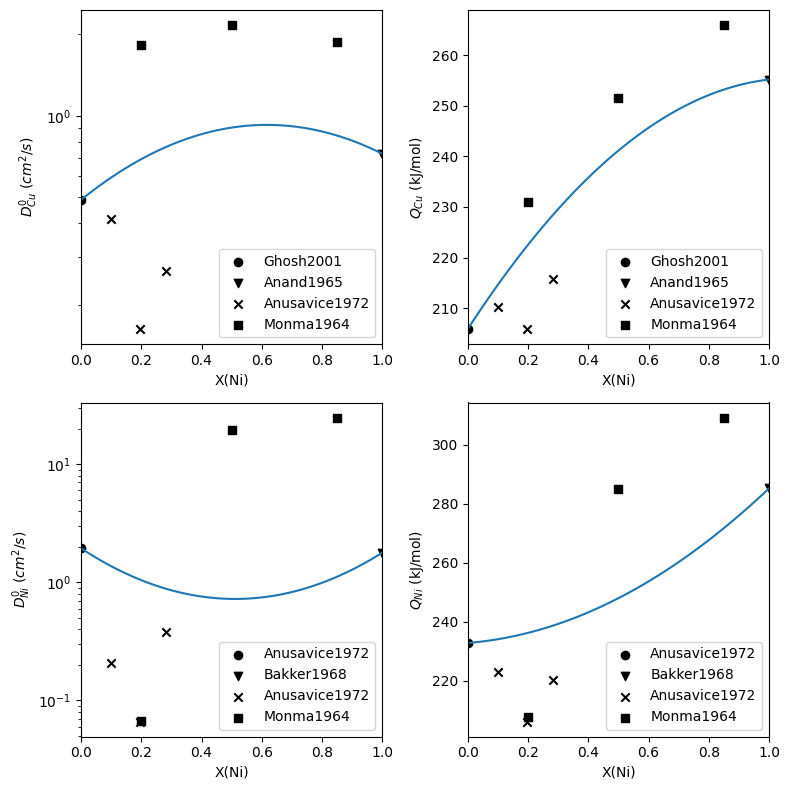

In [3]:
import itertools

import numpy as np
import matplotlib.pyplot as plt

from kawin.thermo import GeneralThermodynamics
from kawin.mobility_fitting.manual_fitting import grab_tracer_datasets
from kawin.thermo.Mobility import activation_energy_from_composition_set_phase_record, prefactor_from_composition_set_phase_record

# Helper function to plot Q or D0 for a given species
def plot_datasets(ax, output, diffusing_species, scale=1):
    symbols = ['o', 'v', 'x', 's', '+', '1', 'd', '_', '^', '<']
    symbol_cycle = itertools.cycle(symbols)

    datasets = grab_tracer_datasets('datasets', output, 'FCC_A1', ['CU', 'NI', 'VA'], diffusing_species)
    for d in datasets:
        sub_config = d['solver']['sublattice_configurations']
        sub_occ = d['solver']['sublattice_occupancies']
        x_ni = []
        for sc, so in zip(sub_config, sub_occ):
            if isinstance(sc[0], str):
                if sc[0] == 'CU':
                    x_ni.append(1-so[0])
                elif sc[0] == 'NI':
                    x_ni.append(so[0])
            else:
                x_ni.append(so[0][sc[0].index('NI')])
        values = np.array(d['values']).flatten()
        ref = d['reference']
        ax.scatter(x_ni, scale*values, label=ref, marker=next(symbol_cycle), color='k')

components = ['CU', 'NI']
phase = 'FCC_A1'
therm = GeneralThermodynamics(dbf, components+['VA'], [phase])

# Compute activation energy and pre-factor for Nb and Ti
N = 50
xs = np.linspace(1e-3, 1-1e-3, N)
T = 1273
lnd0s = np.zeros((N, 2))
qs = np.zeros((N, 2))
for i, x in enumerate(xs):
    results, comp_sets = therm.getLocalEq(x, T, precPhase=[phase])
    qs[i] = activation_energy_from_composition_set_phase_record(comp_sets[0], therm.mob_phase_records, phase, components)
    lnd0s[i] = prefactor_from_composition_set_phase_record(comp_sets[0], therm.mob_phase_records, phase, components)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Plot D0 for Cu mobility
axes[0,0].plot(xs, 1e4*np.exp(lnd0s[:,0]))
plot_datasets(axes[0,0], 'D0', 'CU', scale=1e4)
axes[0,0].set_yscale('log')
axes[0,0].set_ylabel('$D^0_{Cu}$ ($cm^2/s$)')

# Plot Q for Cu mobility
axes[0,1].plot(xs, 1e-3*qs[:,0])
plot_datasets(axes[0,1], 'Q', 'CU', scale=1e-3)
axes[0,1].set_ylabel('$Q_{Cu}$ (kJ/mol)')

# Plot D0 for Ni mobility
axes[1,0].plot(xs, 1e4*np.exp(lnd0s[:,1]))
plot_datasets(axes[1,0], 'D0', 'NI', scale=1e4)
axes[1,0].set_yscale('log')
axes[1,0].set_ylabel('$D^0_{Ni}$ ($cm^2/s$)')

# Plot Q for Ni mobility
axes[1,1].plot(xs, 1e-3*qs[:,1])
plot_datasets(axes[1,1], 'Q', 'NI', scale=1e-3)
axes[1,1].set_ylabel('$Q_{Ni}$ (kJ/mol)')

for ax in axes.reshape(-1):
    ax.set_xlim([0,1])
    ax.set_xlabel('X(Ni)')
    ax.legend()

fig.tight_layout()

plt.show()

### Liquid mobility

Since we don't have any mobility data for the liquid phase, we can estimate them using some available models in the literature. Two models are implemented in kawin:

Y. Liu et al, "A predictive equation for solute diffusivity in liquid metals" Scripta Materialia 55 (2006), 367. doi:10.1016/j.scriptamat.2006.04.019
- $ Q = 0.17 R T_m (16+K_0) $ $ J/mol $
- $ K_0 $ is an integer corresponding to solid phase at melting (BCC = 1, HCP = 2, FCC = 3)
- For self-diffusion: $ D^0_{BB} = (8.95 - 0.0734*A) * 10^{-8} $ $ m^2/s $ where $A$ is atomic number
- For solute-diffusion: $ D^0_{AB} = \frac{r_B}{r_A} D^0_{BB} $ where $r$ is atomic radius
- $ D_AB = D^0_{AB} exp \left( \frac{Q}{R T} \right) $

X. Su et al, "A new equation for temperature dependent solute impurity diffusivity in liquid metals" Journal of Phase Equilibria and Diffusion 31 (2010) 333. doi:10.1007/s11669-010-9726-4
- Sutherland-Einstein equation: $ D = \frac{k T}{4 \pi \mu r} $
- $ \mu_B = \frac{C_1 M_B^{1/2} T^{1/2}}{V_B^{2/3}} exp \left(\frac{C_2 T_{M,B}}{T} \right) $ 
  - $ C_1 = 1.8*10^{-8} $ and $ C_2 = 2.34 $
- Radius in liquid: $ r_A = R_0 \left( \frac{M_A}{\rho_A} \right)^{1/3} \left(1 - 0.122 \left( \frac{T}{T_M} \right)^{1/2} \right) $
  - $ R_0 = 0.644*10^{-10} $
- $ D_{AB} = \frac{k T}{4 \pi \mu_B r_A} $

Both models predict mobility to be within an order of magnitude, so here, we'll add the model from Liu et al to the database due it its simplicity

In [4]:
import matplotlib.pyplot as plt
from pycalphad import Database, variables as v
from kawin.mobility_fitting import generate_liquid_mobility_liu, LiuSpecies
from kawin.mobility_fitting import EquilibriumSiteFractionGenerator

# Create mobility parameters using the Liu model
liu_species = [
        LiuSpecies('CU', diameter=2.55, atomic_number=29, Tm=1358, melting_phase='FCC_A1'),
        LiuSpecies('NI', diameter=2.49, atomic_number=28, Tm=1728, melting_phase='FCC_A1'),
    ]
liu_templates = generate_liquid_mobility_liu(dbf, liu_species)
dbf.to_file('databases/CuNi_mob_gen.tdb', if_exists='overwrite')

We could compare the models from Su et al and Liu et al to see how close the values are and what forms the models take

Liu model for Cu:  (-46404.09216 - 137.295100407725*T)*LIQUID0NI + (-36468.03076 - 137.186121545147*T)*LIQUID0CU
Su model for Cu:  LIQUID0CU*(-26419.56408 + 8.314*T*log(7.223468281731e-10*T**0.5/(1 - 0.00303926198312384*T**0.5))) + LIQUID0NI*(-33617.82528 + 8.314*T*log(7.16032164165535e-10*T**0.5/(1 - 0.00269430125621825*T**0.5)))


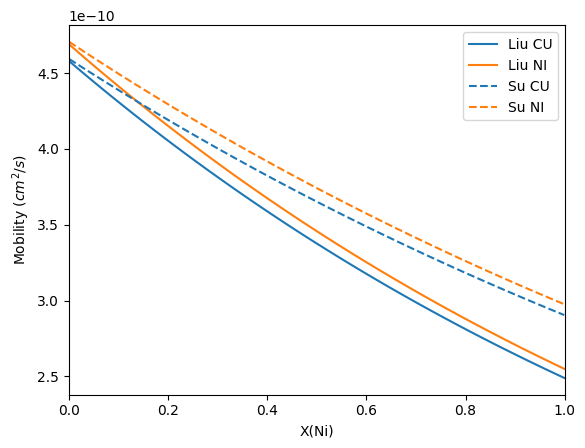

In [5]:
from kawin.mobility_fitting import generate_liquid_mobility_su, SuSpecies

# Create mobility parameters using the Su model
su_species = [
    SuSpecies('CU', atomic_mass=63.55, density=8.96, Tm=1358),
    SuSpecies('NI', atomic_mass=58.69, density=8.90, Tm=1728),
]
# We could disable adding the liquid mobility models to the database
su_templates = generate_liquid_mobility_su(dbf, su_species, add_to_database=False)

print('Liu model for Cu: ', liu_templates['CU'].MQ)
print('Su model for Cu: ', su_templates['CU'].MQ)

fig, ax = plt.subplots()
colors = {'CU': 'C0', 'NI': 'C1'}
conds = {v.T: 2000, v.P: 101325, v.X('NI'): (1e-3, 1-1e-3, 0.01)}

# The SiteFractionGenerator object creates the sitefractions corresponding to 
# a (phase, components, conditions) input. Since we have thermodynamic information
# of the Cu-Ni system, we could use the EquilibriumSiteFractionGenerator
eqgen = EquilibriumSiteFractionGenerator(dbf)

# Plot mobility from Liu and Su model
for s, template in liu_templates.items():
    x, y, var = template.evaluate(template.mobility_function, {}, eqgen, conds)
    ax.plot(x, 1000*y, color=colors[s], linestyle='-', label=f'Liu {s}')

for s, template in su_templates.items():
    x, y, var = template.evaluate(template.mobility_function, {}, eqgen, conds)
    ax.plot(x, 1000*y, color=colors[s], linestyle='--', label=f'Su {s}')
    
ax.set_ylabel(r'Mobility ($cm^2/s$)')
ax.set_xlim([0, 1])
ax.set_xlabel('X(Ni)')
ax.legend()
plt.show()

### Manual fitting

For cases where we don't have diffusion data for all endmembers, we can use the manual fitting module. An example of this would be fitting intermetallics or carbides, where the endmembers may not be thermodynamically stable, and diffusion data cannot be obtained.

The following will show how to manually fit the Cu mobility in the FCC_A1 phase.

In [6]:
from kawin.mobility_fitting import MobilityTemplate
from kawin.mobility_fitting.manual_fitting import grab_tracer_datasets, fit_prefactor, fit_activation_energy, select_best_model
from kawin.mobility_fitting import EquilibriumSiteFractionGenerator

dbf = Database('databases/CuNi.tdb')
eqgen = EquilibriumSiteFractionGenerator(dbf)

phase = 'FCC_A1'
sublattice_model = [1, 1]
constituents = [['CU', 'NI'], ['VA']]
diffusing_species = 'CU'

# Create mobility templates. We'll do three options here: 
# a) no mixing term, b) 1st order mixing, c) 1st and 2nd order mixing
t0 = MobilityTemplate(phase, diffusing_species, sublattice_model, constituents)

t1 = MobilityTemplate(phase, diffusing_species, sublattice_model, constituents)
t1.add_activation_energy([['CU', 'NI'], ['VA']], 0)
t1.add_prefactor([['CU', 'NI'], ['VA']], 0)

t2 = MobilityTemplate(phase, diffusing_species, sublattice_model, constituents)
t2.add_activation_energy([['CU', 'NI'], ['VA']], [0, 1])
t2.add_prefactor([['CU', 'NI'], ['VA']], [0, 1])

# Fit prefactor parameters to data
# Here, we could set the AICC penalty factor to 0.5 by setting p=0.5 in select_best_model
d_data = grab_tracer_datasets('datasets', 'D0', phase, ['CU', 'NI', 'VA'], diffusing_species)
d_model, d_results = select_best_model(d_data, [t0, t1, t2], fit_prefactor, eqgen, p=0.5, return_all_models = True)

# Fit activation energy parameters to data
q_data = grab_tracer_datasets('datasets', 'Q', phase, ['CU', 'NI', 'VA'], diffusing_species)
q_model, q_results = select_best_model(q_data, [t0, t1, t2], fit_activation_energy, eqgen, return_all_models = True)

# Add pre-factor and activation energy parameter to database and save
d_model.template.add_to_database(dbf, d_model.parameters)
q_model.template.add_to_database(dbf, q_model.parameters)
dbf.to_file('databases/CuNi_manual_fit.tdb', if_exists='overwrite')

We could plot the different model templates to view how they fit the data and the AICC value. You may notice that the selected model is different that the one that Espei chooses (the manual fitting selects no mixing parameters while Espei selects a first ordered mixing term). This is because in Espei, the endmembers and mixing parameters are fitting in sequential order, where the data in binary Cu-Ni does not affect the endmember parameters. In the manual fitting module, both the endmembers and mixing parameters are fit in a single step, so the endmember parameters are affected by the binary data.

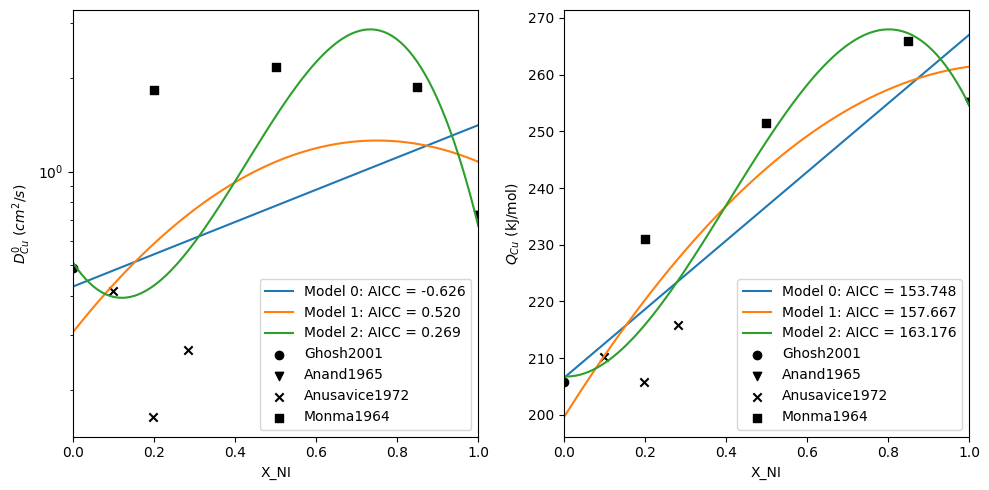

In [7]:
from kawin.mobility_fitting import plot_prefactor, plot_activation_energy

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
conds = {v.T: 1673, v.P: 101325, v.X('NI'): (0, 1, 0.01)}

# Plot prefactor for each template
for i, res in enumerate(d_results):
    plot_prefactor(res.template, res.parameters, eqgen, conditions=conds, ax=ax[0], scale=1e4, label=f'Model {i}: AICC = {res.aicc:.3f}')
plot_datasets(ax[0], 'D0', diffusing_species, scale=1e4)
ax[0].set_ylabel('$D^0_{Cu}$ ($cm^2/s$)')
ax[0].set_yscale('log')
ax[0].legend()

# Plot activation energy for each template
for i, res in enumerate(q_results):
    plot_activation_energy(res.template, res.parameters, eqgen, conditions=conds, ax=ax[1], scale=1e-3, label=f'Model {i}: AICC = {res.aicc:.3f}')
plot_datasets(ax[1], 'Q', diffusing_species, scale=1e-3)
ax[1].set_ylabel('$Q_{Cu}$ (kJ/mol)')
ax[1].legend()

fig.tight_layout()
plt.show()

### References for dataset

1. G. Ghosh, Acta Mater. 49 (2001) 2609.
2. M.S. Anand, S.P. Murarka, R.P. Agarwala, J. Appl. Phys. 36 (1965) 3860.
3. H. Bakker, Phys. Stat. Sol. 28 (1958) 569.
4. K.J. Anusavice, J.J. Pinajian, K. Oikawa, R.T. DeHoff, Trans. Metal. Soc. AIME 242 (1968) 2027.
5. K. Monma, H. Suto, H. Oikawa, J. Japan Inst. Met. 28 (1964) 192.
6. V.T. Heumann, K.J. Grundhoff, Z. Metallk. 63 (1972) 173.
7. Y. Iijima, K. Hirano, M. Kikuchi, Trans. Japan Inst. Met. 23 (1982) 19.